In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import utils
import socks

# Define parameters: api_id, api_hash and proxy server

In [3]:
#chat_id = YOUR_CHAT_ID
API_ID = '329...'
API_HASH = '5f7f7f23f9407bd80f33380c...'
CHAT_NAME = 'Физтех-пати'

# Change the following line to "PROXY_ARGS = None" if you don't use proxy

PROXY_ARGS = (
    socks.SOCKS5,
    '52.178.155.48', # address of your proxy
    31415,  # port of your proxy
    True,
    'username',  # username
    'password',  # password
)

client = utils.start_client(API_ID, API_HASH, PROXY_ARGS)

In [4]:
chat = utils.get_chat(client, CHAT_NAME)
history = utils.get_chat_messages(client, chat)

# messages retrieved: 7328 [01:13, 99.93/s]


# Calc number of messages

In [5]:
stats = []
for user in history:
    stats.append((user, utils.count_messages(history, user)))

import pandas as pd
import numpy as np

message_stats = np.array(sorted(stats, key=lambda x: x[1], reverse=True))
message_stats = pd.DataFrame(index=message_stats[:, 0], data=message_stats[:, 1], columns=['N messages'])
message_stats

,N messages
@Mayorovea,2211
@yeahrmek,872
@junkie_style,820
Pasha,811
@nikitasmagin,603
Дмитрий Новиков,591
@SublimeBot,567
@Yakovets,236
Павел Поглазов,154
@pnovichkov,153


# Calc number of words

In [6]:
words_stats = pd.DataFrame()
for user in history:
    words_stats.loc[user, 'N words'] = utils.count_words(history, user)
words_stats.astype(int)
stats = message_stats.join(words_stats).astype(int)
stats.sort_values(['N words'], ascending=False)

,N messages,N words
@Mayorovea,2211,8095
@SublimeBot,567,7479
Pasha,811,4884
@yeahrmek,872,4396
@nikitasmagin,603,3354
@junkie_style,820,2669
Дмитрий Новиков,591,2356
@pnovichkov,153,1335
@Yakovets,236,842
Pavel,120,841


In [7]:
stats['N words / N messages'] = stats['N words'] / stats['N messages']

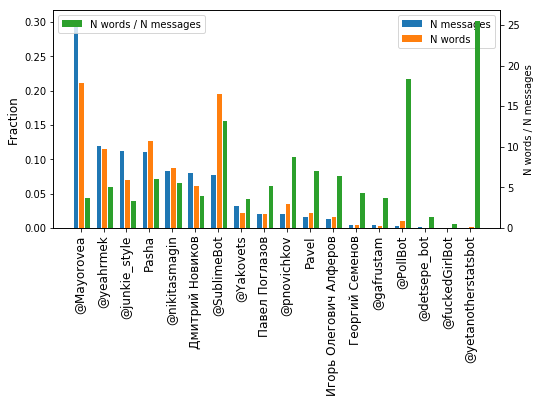

In [8]:
from matplotlib import pyplot as plt

%matplotlib inline

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

locs = np.arange(len(stats)) * 4
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

for i, col_to_plot in enumerate(['N messages', 'N words', 'N words / N messages']):
    if i == 2:
        ax2.bar(locs + i, stats[col_to_plot], label=col_to_plot, color=colors[2])
    else:
        ax1.bar(locs + i, stats[col_to_plot] / stats[col_to_plot].sum(), label=col_to_plot)
    
ax1.set_xticks(locs + 0.8)
ax1.set_xticklabels(stats.index, rotation=90, fontsize=12)
# plt.ylabel(col_to_plot, fontsize=12)
ax1.set_ylabel('Fraction', fontsize=12)
ax2.set_ylabel('N words / N messages')

ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

# Activity

In [9]:
utils.process_dates(history)

In [10]:
def _get_timeline(history):
    times = [pd.Series(h['dates']) for h in history.values()]
    times = pd.concat(times)
    times = times.drop_duplicates().sort_values()
    return times

def _get_n_words(x):
    if x.iloc[0].text is not None:
        return len(x.iloc[0].text.split())
    return 0
    

def get_user_activity_by_words(user_hist, timeline, freq='D'):
    activity = pd.DataFrame(index=timeline, data=np.zeros(len(timeline)), columns=['N words'])
    
    user_messages = pd.DataFrame(index=user_hist['dates'], data=user_hist['raw_messages'], columns=['N words'])
    user_messages = user_messages.apply(_get_n_words, axis=1)
    
    activity.loc[user_hist['dates'], 'N words'] = user_messages
    activity = activity.resample('D').sum()
    return activity

def get_user_activity_by_messages(user_hist, timeline, freq='D'):
    col = 'N messages'
    activity = pd.DataFrame(index=timeline, data=np.zeros(len(timeline)), columns=[col])
    
    user_messages = pd.DataFrame(index=user_hist['dates'], data=np.ones(len(user_hist['dates'])),
                                 columns=[col])
    activity.loc[user_hist['dates'], col] = np.ones(len(user_hist['dates']))
    activity = activity.resample('D').sum()
    return activity

In [11]:
from matplotlib import cm


timeline = _get_timeline(history)
activities = {}
for username in history:
    if not 'bot' in username.lower():
        activities[username] = get_user_activity_by_messages(history[username], timeline)

any_user = list(activities.keys())[0]
activity_matrix = np.zeros((len(activities), len(activities[any_user])))
i = 0
users = []
for user in stats.index:
    if user in activities:
        users.append(user)
        activity_matrix[i] = activities[user].values.ravel()
        i += 1

In [14]:
# get pidor dates
pidor_messages = [m.text for m in history['@SublimeBot']['raw_messages']]
pidor_dates = history['@SublimeBot']['dates']

pidors = pd.DataFrame(index=timeline, columns=users, data=0)

for date, message in zip(pidor_dates, pidor_messages):
    if message.startswith('Топ-') or message.startswith('Согласно '):
        continue
        
    for u in users:
        if u in message:
            pidors.loc[date, u] = 1
pidors = pidors.resample('D').sum()

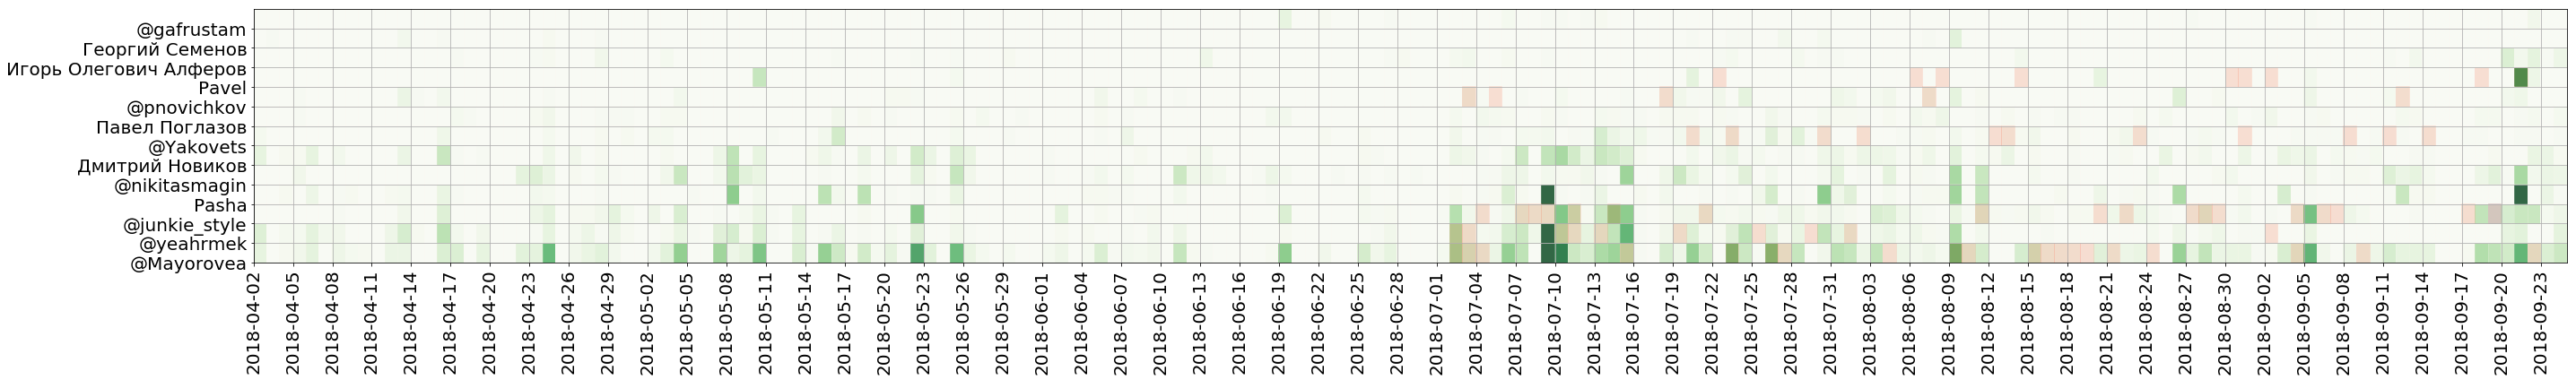

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/site-packages/telethon/client/updates.py", line 232, in _update_loop
    self(functions.updates.GetStateRequest())
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/site-packages/telethon/client/users.py", line 48, in __call__
    result = future.result()
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/concurrent/futures/_base.py", line 432, in result
    return self.__get_result()
  File "/Users/yermek.kapushev/miniconda3/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
ConnectionError



In [18]:
plt.figure(figsize=(40, 6))
height = 40 / activity_matrix.shape[0]
plt.pcolor(activity_matrix, cmap=cm.Greens, vmin=0, vmax=80)

plt.pcolor(pidors.values.T, cmap=cm.Reds, alpha=0.2)

plt.grid(True)
plt.yticks(np.arange(activity_matrix.shape[0]), users, fontsize=20)

step = 3
plt.xticks(np.arange(activity_matrix.shape[1])[::step], activities[any_user].index.strftime('%Y-%m-%d')[::step], 
           rotation=90, fontsize=20)
plt.tight_layout()
plt.show()

In [25]:
# fig = plt.figure(figsize=(15,8))
# ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

# the_table=plt.table(cellText=None, rowLabels=users, colLabels=activities[any_user].index.strftime('%Y-%m-%d'), 
#                     colWidths=[0.01]*activity_matrix.shape[1], loc='center', 
#                     cellColours=cm.Greens(activity_matrix))

# Calc number of bytes

In [94]:
stats = []
for user in history:
    stats.append((user, utils.count_bytes(history, user)))
    
stats = sorted(stats, key=lambda x: x[1], reverse=True)
for user, count in stats:
    print('{}: {}'.format(user, count))

MessageMediaPhoto(
	photo=Photo(
		id=5211056796758812921,
		access_hash=-3287645354270266590,
		date=datetime.datetime(2018, 9, 1, 8, 17, 47, tzinfo=datetime.timezone.utc),
		sizes=[
			PhotoSize(
				type='s',
				location=FileLocation(
					dc_id=2,
					volume_id=246931051,
					local_id=188928,
					secret=-5396318257382122520
				),
				w=67,
				h=90,
				size=1859
			),
			PhotoSize(
				type='m',
				location=FileLocation(
					dc_id=2,
					volume_id=246931051,
					local_id=188929,
					secret=4461106057927310215
				),
				w=240,
				h=320,
				size=34633
			),
			PhotoSize(
				type='x',
				location=FileLocation(
					dc_id=2,
					volume_id=246931051,
					local_id=188931,
					secret=-3504840851122401978
				),
				w=600,
				h=800,
				size=148579
			),
			PhotoSize(
				type='y',
				location=FileLocation(
					dc_id=2,
					volume_id=246931051,
					local_id=188930,
					secret=-2638084262274514319
				),
				w=960,
				h=1280,
				size=242818
			),
		],
		has_sticke

(Pdb)  c


MessageMediaPhoto(
	photo=Photo(
		id=5406637431186368844,
		access_hash=508535252008707304,
		date=datetime.datetime(2018, 8, 1, 16, 27, 25, tzinfo=datetime.timezone.utc),
		sizes=[
			PhotoSize(
				type='s',
				location=FileLocation(
					dc_id=2,
					volume_id=239518079,
					local_id=310544,
					secret=-1806036180475874440
				),
				w=90,
				h=60,
				size=1440
			),
			PhotoSize(
				type='m',
				location=FileLocation(
					dc_id=2,
					volume_id=239518079,
					local_id=310545,
					secret=-2515543480421215262
				),
				w=320,
				h=214,
				size=13588
			),
			PhotoSize(
				type='x',
				location=FileLocation(
					dc_id=2,
					volume_id=239518079,
					local_id=310546,
					secret=-4190000635609600294
				),
				w=800,
				h=534,
				size=53637
			),
			PhotoSize(
				type='y',
				location=FileLocation(
					dc_id=2,
					volume_id=239518079,
					local_id=310543,
					secret=-7484898815649303401
				),
				w=850,
				h=567,
				size=47706
			),
		],
		has_stickers=

(Pdb)  c


MessageMediaPhoto(
	photo=Photo(
		id=5400365494738987394,
		access_hash=1189304189856359290,
		date=datetime.datetime(2018, 7, 30, 5, 59, 57, tzinfo=datetime.timezone.utc),
		sizes=[
			PhotoSize(
				type='s',
				location=FileLocation(
					dc_id=2,
					volume_id=246929567,
					local_id=104804,
					secret=-1861005138801425500
				),
				w=28,
				h=90,
				size=1160
			),
			PhotoSize(
				type='m',
				location=FileLocation(
					dc_id=2,
					volume_id=246929567,
					local_id=104805,
					secret=-490046745839850919
				),
				w=100,
				h=320,
				size=17799
			),
			PhotoSize(
				type='x',
				location=FileLocation(
					dc_id=2,
					volume_id=246929567,
					local_id=104807,
					secret=-5114715188526221879
				),
				w=251,
				h=800,
				size=85816
			),
			PhotoSize(
				type='y',
				location=FileLocation(
					dc_id=2,
					volume_id=246929567,
					local_id=104806,
					secret=4441311368534617172
				),
				w=402,
				h=1280,
				size=165728
			),
		],
		has_stickers

(Pdb)  c


MessageMediaWebPage(
	webpage=WebPage(
		id=1503448450617848398,
		url='https://www.youtube.com/watch?v=z9pD_UK6vGU&feature=youtu.be',
		display_url='youtube.com/watch?v=z9pD_UK6vGU',
		hash=0,
		type='video',
		site_name='YouTube',
		title='MinusIQ | The pill to lower your IQ permanently',
		description="The world's a much brighter place when you're not too bright for it. http://www.sleepthinker.com http://www.facebook.com/sleepthinker",
		photo=Photo(
			id=532577942320506501,
			access_hash=42826554738035066,
			date=datetime.datetime(2017, 8, 16, 19, 42, 28, tzinfo=datetime.timezone.utc),
			sizes=[
				PhotoSize(
					type='s',
					location=FileLocation(
						dc_id=4,
						volume_id=811821857,
						local_id=170143,
						secret=-8385665881153045995
					),
					w=90,
					h=51,
					size=1136
				),
				PhotoSize(
					type='m',
					location=FileLocation(
						dc_id=4,
						volume_id=811821857,
						local_id=170144,
						secret=-3411485316068268381
					),
					w=320,
			

(Pdb)  c


AttributeError: 'MessageMediaWebPage' object has no attribute 'photo'

# Calculate messages after pidor bot was added

In [7]:
utils.process_dates(history)

pidor_date = history['@PollBot']['dates'][-1]
messages_after_pidor_bot = utils.count_messages_after_date(history, pidor_date)
for user in sorted(messages_after_pidor_bot, key=lambda x: messages_after_pidor_bot[x], reverse=True):
    print('{}: {}'.format(user, messages_after_pidor_bot[user]))

@Mayorovea: 956
@SublimeBot: 423
@junkie_style: 401
Pasha: 348
@yeahrmek: 305
@nikitasmagin: 303
Дмитрий Новиков: 197
@Yakovets: 122
@pnovichkov: 107
Pavel: 93
Павел Поглазов: 80
Игорь Олегович Алферов: 51
Георгий Семенов: 24
@PollBot: 20
@gafrustam: 7
@detsepe_bot: 5
@yetanotherstatsbot: 2
@fuckedGirlBot: 0


In [87]:
m.media.document.size

46046